In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import oneDhomoTurb
import cantera as ct
from scipy.interpolate import interp1d

In [6]:
nrlz = 288
rho = 1.80394
mu = 8.068822E-6
djet = 0.526E-2        # m
uavg = 53.0            # m/s
umua = 69.876/53.0     #1.23            # umax/uavg 1.28
T = 294.
P = 100000.

gas = ct.Solution("../propaneAir.xml")
gas.TPX = T,P,"O2:0.21, N2:0.79"
y0 = gas.Y
gas.TPX = T,P,"C3H8:1.0"
y1 = gas.Y

Re = rho*djet*uavg/mu
umax = umua*uavg       # m/s
rjet = djet * 0.5      # m
nu = mu/rho

def colbrook(f,Re) :
    return 1.0/np.sqrt(f) + 2.0*np.log10(2.51/Re/np.sqrt(f))
 
f = fsolve(colbrook, 0.02, args=(Re))
dpdx = -f*rho*uavg**2.0/2.0/djet

utau = (-djet/2/rho*dpdx)**0.5
delta_nu = nu/utau
Retau = nu/delta_nu
tau_flow = djet/uavg
L_entry = djet*1.359*Re**0.25
tau_entry = L_entry/uavg

In [7]:
ht = oneDhomoTurb.homoturb(nu=nu, rho=rho, L=djet, Li=0.038*djet, \
                           up=uavg*0.16*Re**(-1/8), specifyUprime=True)
ht.setEspectrum()

for it in range(nrlz) :
    
    print("it = %i of %i" %(it+1, nrlz))

    ht.getUprofile()
    #ht.output(LdoPlot=True)
    uturb = ht.u.copy()
    rj    = ht.x - djet/2.0
    rj = np.append(rj, djet/2.0)
    uturb = np.append(uturb, uturb[0])
    uturb[0] = 0
    uturb[-1] = 0
    npts  = len(rj)
    
    #-----------------------
    
    #aa = 2.0*(1.0-umua)
    #bb = 3.0
    #cc = 1.0
    #npow = (-bb-np.sqrt(bb**2.0 - 4.0*aa*cc))/2.0/aa
    #uj = umax * (1.0-np.abs(rj)/rjet)**(1.0/npow) + uturb
    
    uj = umax + 1.0/0.41*utau*(np.sqrt(np.abs(rj)/rjet) + \
                               np.log(1.0-np.sqrt(np.abs(rj)/rjet))) + uturb
    uj[np.where(np.isinf(uj))] = 0.0
    
    #------------------------
    
    rcfp = np.array([0.51, 0.86538, 1, 1.1, 1.2, 1.4, 1.7, 1.8, 2.5, 3.2, 3.8, 4, 6, 8, 10])*djet    
    rcfm = -np.flipud(rcfp)
    ucfp = np.array([0,0,0,4.5,7.9,8.25,8.6,8.7,9,9.15,9.25,9.25,9.25,9.25,9.25])
    ucfm = np.flipud(ucfp)
    
    #------------------------
    
    r = np.hstack((rcfm, rj, rcfp))
    u = np.hstack((ucfm, uj, ucfp))
    u[np.where(u<0.001)] = 0.5
    
    #------------------------
    
    posf = r.copy()
    pos = 0.5*(posf[1:]+posf[0:-1])
    fi = interp1d(posf,u,kind='linear')
    u = fi(pos)
    
    mixf = np.zeros(len(pos))
    mixf[np.where(np.logical_and(pos>=-djet/2, pos<=djet/2))] = 1.0
    
    chi = np.zeros(len(mixf))
    vvel = np.zeros(len(mixf))
    wvel = np.zeros(len(mixf))
    rho = np.zeros(len(mixf))
    dvisc = np.zeros(len(mixf))
    y = np.zeros((len(mixf), gas.n_species))
    for i in range(len(mixf)) :
        y[i,:] = y0*(1-mixf[i]) + y1*(mixf[i])
        gas.TPY = T,P,y[i,:]
        rho[i] = gas.density
        dvisc[i] = gas.viscosity
        
    var = np.vstack( (pos, posf[:-1], rho, dvisc, u, vvel, wvel, mixf, chi, y.T) ).T 
    
    header = "time = 0\nGrid points = %i\nDomain Size = %g\nPressure (Pa) = %g\n" %(len(pos),posf[-1]-posf[0],P)
    header += "            1_pos             2_posf             3_rho             4_dvisc             5_uvel             6_vvel             7_wvel             8_mixf             9_chi            10_y_O2            11_y_N2            12_y_C3H8"
            
    fname = "../restart/restart_" + "{0:0>5}".format(it) + ".dat"
    np.savetxt(fname, var, header=header, fmt=" %17.10E")
    

/usr/local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log


it = 1 of 288
it = 2 of 288
it = 3 of 288
it = 4 of 288
it = 5 of 288
it = 6 of 288
it = 7 of 288
it = 8 of 288
it = 9 of 288
it = 10 of 288
it = 11 of 288
it = 12 of 288
it = 13 of 288
it = 14 of 288
it = 15 of 288
it = 16 of 288
it = 17 of 288
it = 18 of 288
it = 19 of 288
it = 20 of 288
it = 21 of 288
it = 22 of 288
it = 23 of 288
it = 24 of 288
it = 25 of 288
it = 26 of 288
it = 27 of 288
it = 28 of 288
it = 29 of 288
it = 30 of 288
it = 31 of 288
it = 32 of 288
it = 33 of 288
it = 34 of 288
it = 35 of 288
it = 36 of 288
it = 37 of 288
it = 38 of 288
it = 39 of 288
it = 40 of 288
it = 41 of 288
it = 42 of 288
it = 43 of 288
it = 44 of 288
it = 45 of 288
it = 46 of 288
it = 47 of 288
it = 48 of 288
it = 49 of 288
it = 50 of 288
it = 51 of 288
it = 52 of 288
it = 53 of 288
it = 54 of 288
it = 55 of 288
it = 56 of 288
it = 57 of 288
it = 58 of 288
it = 59 of 288
it = 60 of 288
it = 61 of 288
it = 62 of 288
it = 63 of 288
it = 64 of 288
it = 65 of 288
it = 66 of 288
it = 67 of 288
it =

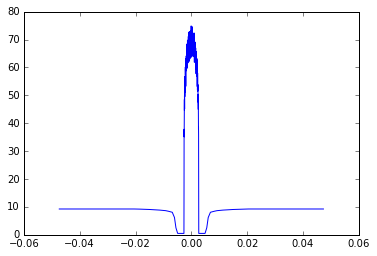

In [8]:
plt.plot(pos,u) 